In [ ]:
# !pip install statsmodels


In [3]:
import numpy
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
from statsmodels.tsa.api import VAR,VARMAX



def get_features():
    df_on_chain = pd.read_csv('./BNB_amount_to_data.csv', index_col=[0])
    df_on_chain = df_on_chain[(df_on_chain.T != 0).any()]

    df_on_chain = df_on_chain[df_on_chain.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

    sc_in = MinMaxScaler(feature_range=(0, 1))
    scaled_columns = df_on_chain.reset_index().drop('ts', axis=1).columns
    scaled_input = sc_in.fit_transform(df_on_chain[scaled_columns])
    df_on_chain[scaled_columns] = scaled_input
    df_on_chain[df_on_chain[scaled_columns] > 0] += 1
    #     df_on_chain = pd.concat([df_on_chain.shift(),df_off_chain.shift()],axis=1)
    x_raw = df_on_chain.to_numpy()
    time_dim = x_raw.shape[0]
    x_raw = np.concatenate((x_raw, np.ones(shape=[time_dim, 1]) * 0.03), axis=1)
    return x_raw[:-1]


def preprocess_data():
    with open('./BNB_amount_to_beta.npy', 'rb') as f:
        b_var = np.load(f)
    b_var = np.reshape(b_var, (b_var.shape[0], b_var.shape[1]))[:,6:12]

    return b_var*100


def create_dataset(Betas,time_steps=2):
    Xs, ys = [], []
    for i in range(len(Betas) - time_steps):
        v = Betas[i:(i + time_steps)]
        # q = X[i:(i + time_steps)]
        # v = np.concatenate((v,q),1)
        Xs.append(v)
        # Xs.append(np.reshape(v,time_steps*v.shape[1]))
        ys.append(Betas[i + time_steps])
    return np.array(Xs), np.array(ys)

# X,y = preprocess_data()
X = preprocess_data()
in_p,out = create_dataset(X,20)


In [4]:
model = VAR(X)
result = model.fit(20)

In [14]:
out2= []
for i in range(out.shape[0]):
    out2.append(result.forecast(in_p[i],1))
out21 = np.array(out2)
arr_out = np.reshape(out21,(out21.shape[0],out21.shape[2]))*10

In [21]:
np.mean(np.mean(abs(arr_out - out),axis=0)),np.mean(np.mean((arr_out - out)**2,axis=0))

(2.68221681326794, 15.74415505237482)

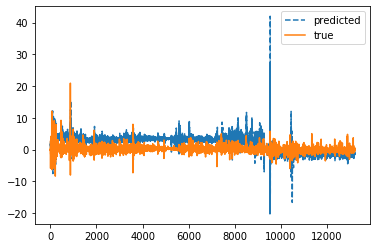

In [23]:
import matplotlib.pyplot as plt
plt.plot(arr_out[:,1],linestyle="--",label="predicted")
plt.plot(out[:,1],label="true")
plt.legend()
plt.legend()
plt.savefig('VAR_train')

In [24]:
def plot_beta_with_datetime(beta_dataframe, pred_df, name, dates=[], save=False):
    y = dates

    sns.set(font_scale=1.5, style="white")

    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.xaxis_date()
    ax.plot(y[20:],
           beta_dataframe.iloc[20:,7],label="true")
    ax.plot(y[20:],
           pred_df.iloc[:,1],linestyle="-.",label="predicted", color="burlywood")

    ax.set(xlabel="Date",
           ylabel="Latent Parameter beta")
    date_form = DateFormatter("%y-%m-%d")
    ax.xaxis.set_major_formatter(date_form)
    plt.legend()
    if save:
        plt.savefig('BNB_amount_to_y_price_x_diff_beta_VAR_' + name + '.png')
   
    plt.show()

    

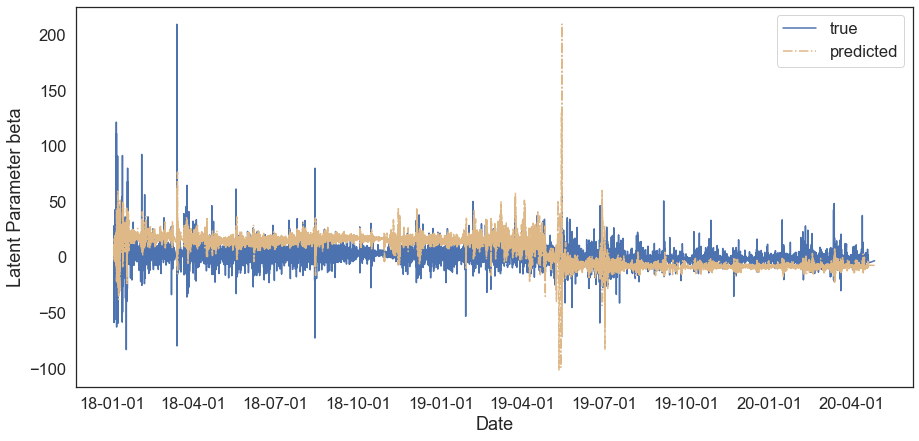

In [27]:
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

beta_amount = pd.read_csv('../data/BNB_amount_to_data.csv', index_col=[0])


beta_amount = beta_amount[beta_amount.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
beta_amount = beta_amount[(beta_amount.T != 0).any()]

beta_amount = beta_amount.reset_index()
beta_amount['dates'] = beta_amount.ts.apply(lambda x: datetime.datetime.fromtimestamp(x))
b_var_pred_train = arr_out*5 - 0.5

with open('./BNB_amount_to_beta.npy', 'rb') as f:
      b_var2 = np.load(f)*1000
b_var2 = np.reshape(b_var2,(b_var2.shape[0],b_var2.shape[1]))

b_var_pd = pd.DataFrame(b_var2)
beta_pred = pd.DataFrame(b_var_pred_train)
plot_beta_with_datetime(b_var_pd,beta_pred,'Binance',beta_amount['dates'][1:],True)
